# Azure Speech to text with duration and offsets

In [1]:
import azure.cognitiveservices.speech as speechsdk
import json
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import time
import wave

from dotenv import load_dotenv
from IPython.display import Audio
from pprint import pprint
from pydub import AudioSegment

In [2]:
sys.version

'3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]'

In [3]:
load_dotenv("azure.env")

azure_speech_key = os.getenv("AZURE_SPEECH_KEY")
azure_service_region = os.getenv("AZURE_SPEECH_REGION")

## 1. Functions

In [4]:
def get_audio_duration(audiofile):
    """
    Get audio duration
    """
    with wave.open(audiofile, "rb") as audio_file:
        num_frames = audio_file.getnframes()
        frame_rate = audio_file.getframerate()
        duration = num_frames / float(frame_rate)

    print(f"Duration of {audiofile} = {duration} seconds")

In [5]:
def display_amplitude(audiofile):
    """
    Get amplitude plot from a local audio file
    """
    plt.figure(figsize=(15, 5))
    # Reading the sound file
    y, sr = librosa.load(audiofile)
    # amplitude plot
    librosa.display.waveshow(y, sr=sr)
    title = "Waveplot: " + audiofile
    plt.title(title, fontdict=dict(size=15))
    plt.xlabel("Time", fontdict=dict(size=12))
    plt.ylabel("Amplitude", fontdict=dict(size=12))

    plt.show()

In [14]:
def display_fft(audiofile):
    """
    Get FFT plot from a local audio file
    """
    plt.figure(figsize=(15, 5))

    # Reading the audio file
    y, sr = librosa.load(audiofile)
    # Creating a Discrete-Fourier Transform with our FFT algorithm
    fast_fourier_transf = np.fft.fft(y)
    # Magnitudes indicate the contribution of each frequency
    magnitude = np.abs(fast_fourier_transf)
    # mapping the magnitude to the relative frequency bins
    frequency = np.linspace(0, sr, len(magnitude))
    # We only need the first half of the magnitude and frequency
    left_mag = magnitude[: int(len(magnitude) / 2)]
    left_freq = frequency[: int(len(frequency) / 2)]

    title = "Discrete-Fourier Transform: " + audiofile
    plt.plot(left_freq, left_mag)
    plt.title(title, fontdict=dict(size=15))
    plt.xlabel("Frequency", fontdict=dict(size=12))
    plt.ylabel("Magnitude", fontdict=dict(size=12))

    plt.show()

In [18]:
def display_mel_spectogram(audiofile, n_fft=1024, hop_length=512):
    """
    Get MEL spectogram from a local audio file
    """
    plt.figure(figsize=(15, 5))

    # n_fft: this is the number of samples in a window per fft
    # hop_length: The amount of samples we are shifting after each fft

    # reading audio file
    y, sr = librosa.load(audiofile)
    # mel spectogram
    mel_signal = librosa.feature.melspectrogram(
        y=y, sr=sr, hop_length=hop_length, n_fft=n_fft
    )
    spectrogram = np.abs(mel_signal)
    power_to_db = librosa.power_to_db(spectrogram, ref=np.max)
    librosa.display.specshow(
        power_to_db,
        sr=sr,
        x_axis="time",
        y_axis="mel",
        cmap="magma",
        hop_length=hop_length,
    )

    title = "Mel-Spectogram (dB): " + audiofile
    plt.title(title, fontdict=dict(size=15))
    plt.xlabel("Time", fontdict=dict(size=12))
    plt.ylabel("Frequency", fontdict=dict(size=12))
    plt.colorbar(label="dB")

    plt.show()

In [19]:
def display_chromagram(audiofile):
    """
    Get chromagram from a local audio file
    """
    plt.figure(figsize=(15, 5))

    # reading audio file
    y, sr = librosa.load(audiofile)
    # Chromagram
    chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
    librosa.display.specshow(chromagram, x_axis="time", y_axis="chroma", cmap="magma")
    plt.colorbar(format="%+2.0f dB")
    title = "Chromagram: " + audiofile
    plt.title(title)
    plt.show()

## 2. Audio file

In [20]:
audiofile = "sample.wav"

In [21]:
Audio(audiofile, autoplay=False)

In [22]:
get_audio_duration(audiofile)

Duration of sample.wav = 2.03 seconds


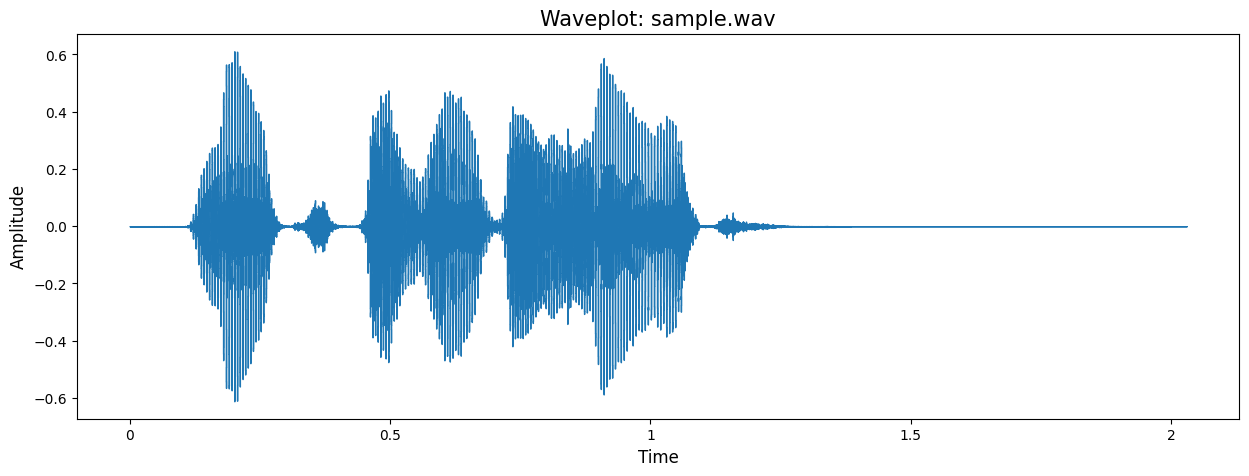

In [23]:
display_amplitude(audiofile)

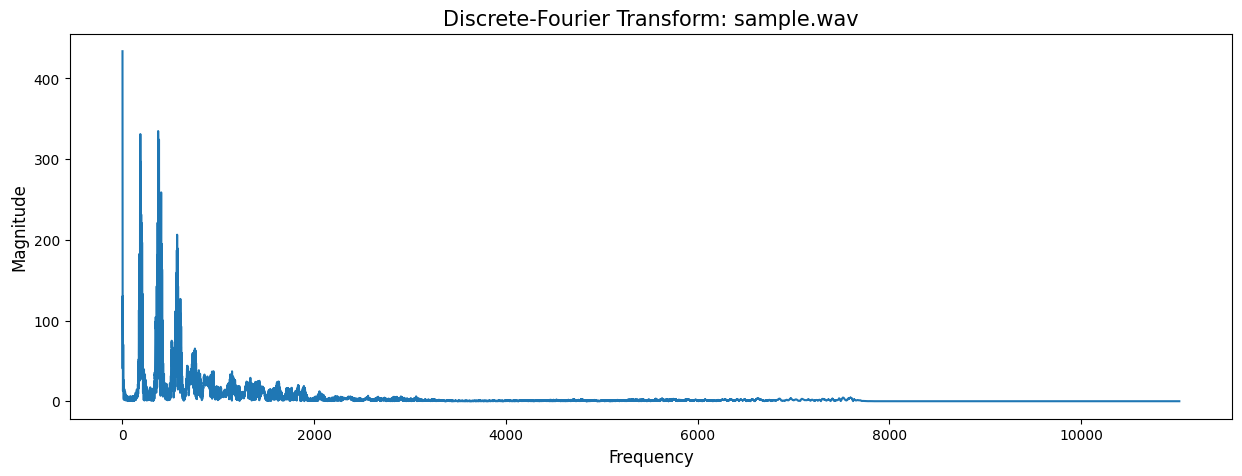

In [24]:
display_fft(audiofile)

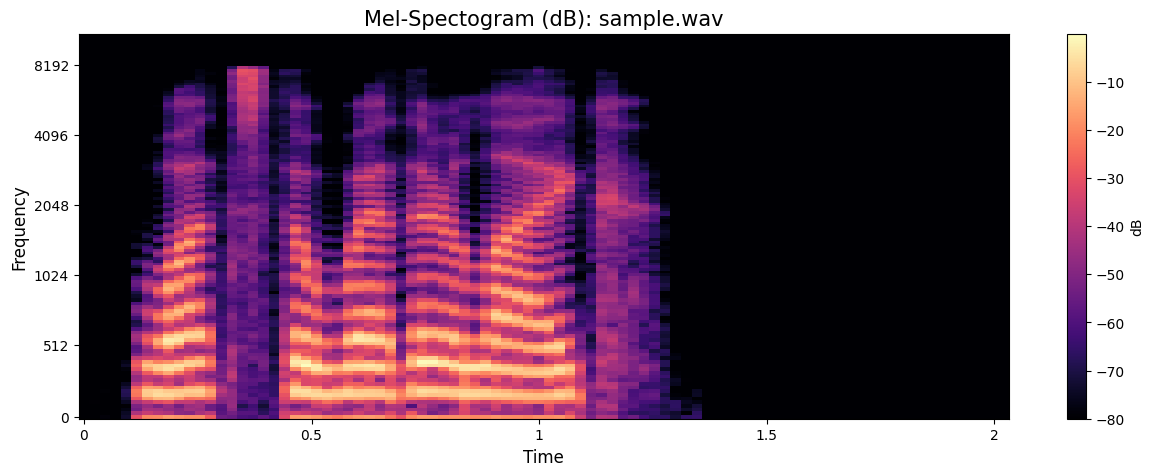

In [25]:
display_mel_spectogram(audiofile, n_fft=1024, hop_length=512)

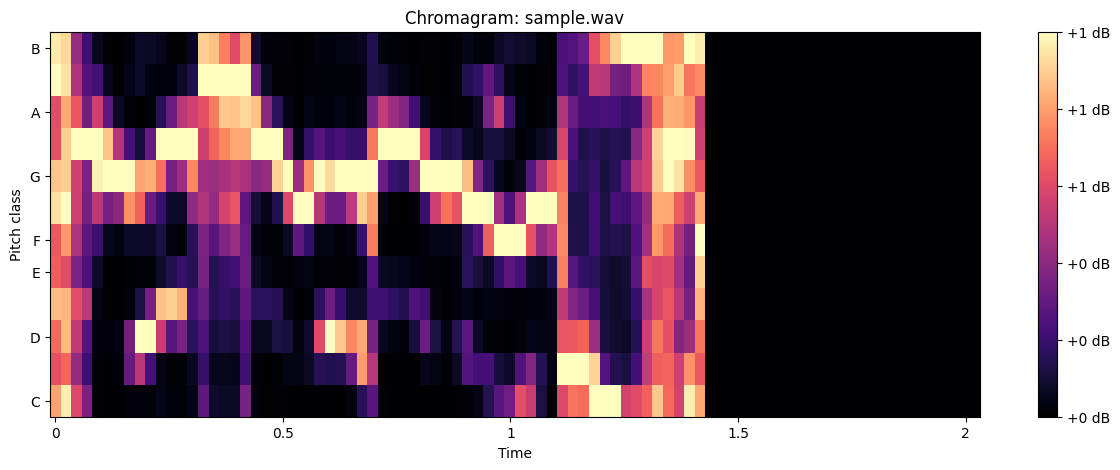

In [26]:
display_chromagram(audiofile)

## 3. Azure Speech services for Speech to Text

In [27]:
speech_key, service_region = azure_speech_key, azure_service_region

In [28]:
def speech_to_text(audiofile, wordlevel):
    """
    Azure Speech to text
    """
    speech_config = speechsdk.SpeechConfig(
        subscription=speech_key, region=service_region
    )

    if wordlevel:  # To display the result at the word level
        speech_config.request_word_level_timestamps()

    audio_config = speechsdk.audio.AudioConfig(filename=audiofile)
    speech_recognizer = speechsdk.SpeechRecognizer(
        speech_config=speech_config, audio_config=audio_config
    )
    result = speech_recognizer.recognize_once()

    jsonfile = result.json
    pprint(jsonfile)

    return jsonfile

### 3.1 Word level

In [29]:
res = speech_to_text(audiofile, wordlevel=True)

('{"Id":"765a8f948bb34531ac25e4b9f9498581","RecognitionStatus":"Success","Offset":1500000,"Duration":12100000,"Channel":0,"DisplayText":"What\'s '
 'the weather like?","NBest":[{"Confidence":0.954211,"Lexical":"what\'s the '
 'weather like","ITN":"what\'s the weather like","MaskedITN":"what\'s the '
 'weather like","Display":"What\'s the weather '
 'like?","Words":[{"Word":"what\'s","Offset":1500000,"Duration":3500000,"Confidence":0.9162892},{"Word":"the","Offset":5100000,"Duration":1200000,"Confidence":0.98080814},{"Word":"weather","Offset":6400000,"Duration":3000000,"Confidence":0.937425},{"Word":"like","Offset":9500000,"Duration":4100000,"Confidence":0.99087274}]},{"Confidence":0.9444519,"Lexical":"what\'s '
 'the weather like in","ITN":"what\'s the weather like '
 'in","MaskedITN":"what\'s the weather like in","Display":"what\'s the weather '
 'like '
 'in","Words":[{"Word":"what\'s","Offset":1500000,"Duration":3500000,"Confidence":0.9162892},{"Word":"the","Offset":5100000,"Duratio

In [30]:
stt = json.loads(res)
confidences_in_nbest = [item["Confidence"] for item in stt["NBest"]]
best_index = confidences_in_nbest.index(max(confidences_in_nbest))
words = stt["NBest"][best_index]["Words"]
print(words)

[{'Word': "what's", 'Offset': 1500000, 'Duration': 3500000, 'Confidence': 0.9162892}, {'Word': 'the', 'Offset': 5100000, 'Duration': 1200000, 'Confidence': 0.98080814}, {'Word': 'weather', 'Offset': 6400000, 'Duration': 3000000, 'Confidence': 0.937425}, {'Word': 'like', 'Offset': 9500000, 'Duration': 4100000, 'Confidence': 0.99087274}]


- Offset: The offset into the audio stream being recognized, expressed as duration. Offset is measured in ticks, starting from 0 (zero) tick, associated with the first audio byte processed by the SDK. For example, the offset begins when you start recognition, since that's when the SDK starts processing the audio stream. One tick represents one hundred nanoseconds or one ten-millionth of a second.

- Duration: Duration of the utterance that is being recognized. The duration in ticks doesn't include trailing or leading silence.

In [31]:
words

[{'Word': "what's",
  'Offset': 1500000,
  'Duration': 3500000,
  'Confidence': 0.9162892},
 {'Word': 'the',
  'Offset': 5100000,
  'Duration': 1200000,
  'Confidence': 0.98080814},
 {'Word': 'weather',
  'Offset': 6400000,
  'Duration': 3000000,
  'Confidence': 0.937425},
 {'Word': 'like',
  'Offset': 9500000,
  'Duration': 4100000,
  'Confidence': 0.99087274}]

In [32]:
df = pd.DataFrame(words, columns=["Word", "Offset", "Duration", "Confidence"])
df["Offset_in_secs"] = df["Offset"] / 10000000
df["Duration_in_secs"] = df["Duration"] / 10000000
df

,Word,Offset,Duration,Confidence,Offset_in_secs,Duration_in_secs
0,what's,1500000,3500000,0.916289,0.15,0.35
1,the,5100000,1200000,0.980808,0.51,0.12
2,weather,6400000,3000000,0.937425,0.64,0.30
3,like,9500000,4100000,0.990873,0.95,0.41


### 3.2 No word level

In [33]:
res = speech_to_text(audiofile, wordlevel=False)

('{"Id":"4f7a1076794e495e81466a068ba2e068","RecognitionStatus":"Success","DisplayText":"What\'s '
 'the weather like?","Offset":1500000,"Duration":12100000,"Channel":0}')


In [34]:
stt = json.loads(res)
stt

{'Id': '4f7a1076794e495e81466a068ba2e068',
 'RecognitionStatus': 'Success',
 'DisplayText': "What's the weather like?",
 'Offset': 1500000,
 'Duration': 12100000,
 'Channel': 0}

In [35]:
print(
    stt["DisplayText"],
    "with offset =",
    stt["Offset"],
    "and duration =",
    stt["Duration"],
)

What's the weather like? with offset = 1500000 and duration = 12100000


### 3.3 Full text

In [36]:
def azure_tts(audio_filepath, locale):
    """
    Azure TTS
    """
    audio_config = speechsdk.audio.AudioConfig(filename=audio_filepath)
    speech_config = speechsdk.SpeechConfig(
        subscription=azure_speech_key, region=azure_service_region
    )
    speech_config.request_word_level_timestamps()
    speech_config.speech_recognition_language = locale
    speech_config.output_format = speechsdk.OutputFormat(1)

    # Creates a recognizer with the given settings
    speech_recognizer = speechsdk.SpeechRecognizer(
        speech_config=speech_config, audio_config=audio_config
    )

    # Variable to monitor status
    done = False

    # Service callback for recognition text
    transcript_display_list = []
    transcript_ITN_list = []
    confidence_list = []
    words = []

    def parse_azure_result(evt):
        import json

        response = json.loads(evt.result.json)
        transcript_display_list.append(response["DisplayText"])
        confidence_list_temp = [item.get("Confidence") for item in response["NBest"]]
        max_confidence_index = confidence_list_temp.index(max(confidence_list_temp))
        confidence_list.append(response["NBest"][max_confidence_index]["Confidence"])
        transcript_ITN_list.append(response["NBest"][max_confidence_index]["ITN"])
        words.extend(response["NBest"][max_confidence_index]["Words"])

    # Service callback that stops continuous recognition upon receiving an event `evt`
    def stop_cb(evt):
        print("CLOSING on {}".format(evt))
        speech_recognizer.stop_continuous_recognition()
        nonlocal done
        done = True

        # Do something with the combined responses
        print(transcript_display_list)
        print(confidence_list)
        print(words)

    # Connect callbacks to the events fired by the speech recognizer
    speech_recognizer.recognizing.connect(
        lambda evt: logger.debug("RECOGNIZING: {}".format(evt))
    )
    speech_recognizer.recognized.connect(parse_azure_result)
    speech_recognizer.session_started.connect(
        lambda evt: logger.debug("SESSION STARTED: {}".format(evt))
    )
    speech_recognizer.session_stopped.connect(
        lambda evt: logger.debug("SESSION STOPPED {}".format(evt))
    )
    speech_recognizer.canceled.connect(
        lambda evt: logger.debug("CANCELED {}".format(evt))
    )
    # stop continuous recognition on either session stopped or canceled events
    speech_recognizer.session_stopped.connect(stop_cb)
    speech_recognizer.canceled.connect(stop_cb)

    # Start continuous speech recognition
    speech_recognizer.start_continuous_recognition()
    while not done:
        time.sleep(0.5)

    return transcript_display_list, confidence_list, words

In [37]:
audiofile = "audio.wav"
language = "fr-FR"

In [39]:
get_audio_duration(audiofile)

Duration of audio.wav = 80.0 seconds


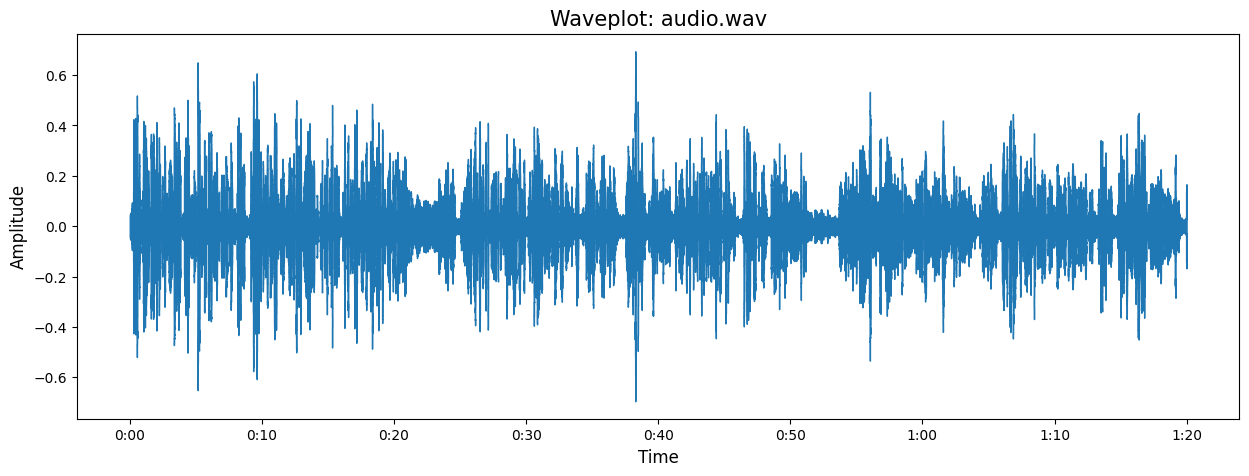

In [40]:
display_amplitude(audiofile)

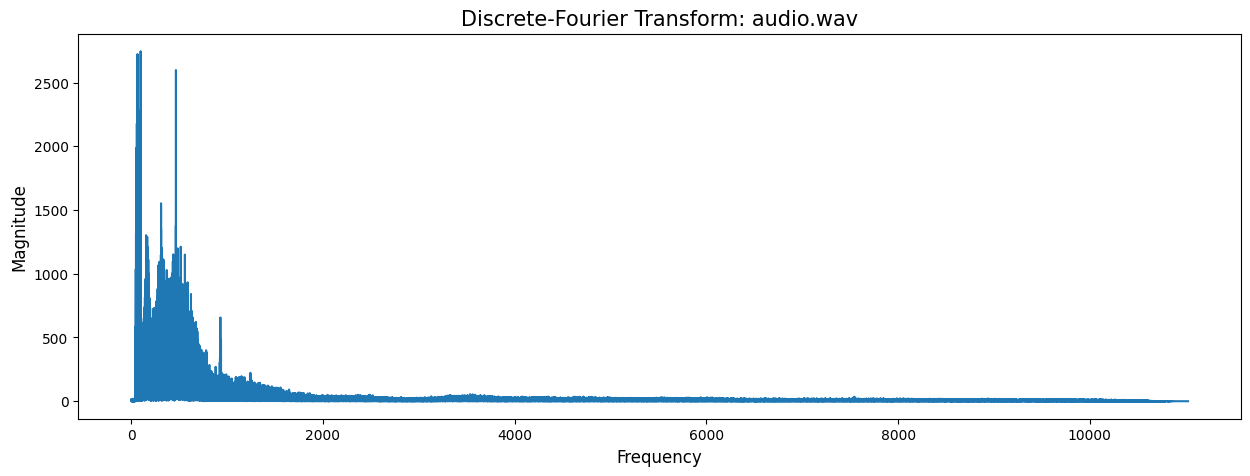

In [41]:
display_fft(audiofile)

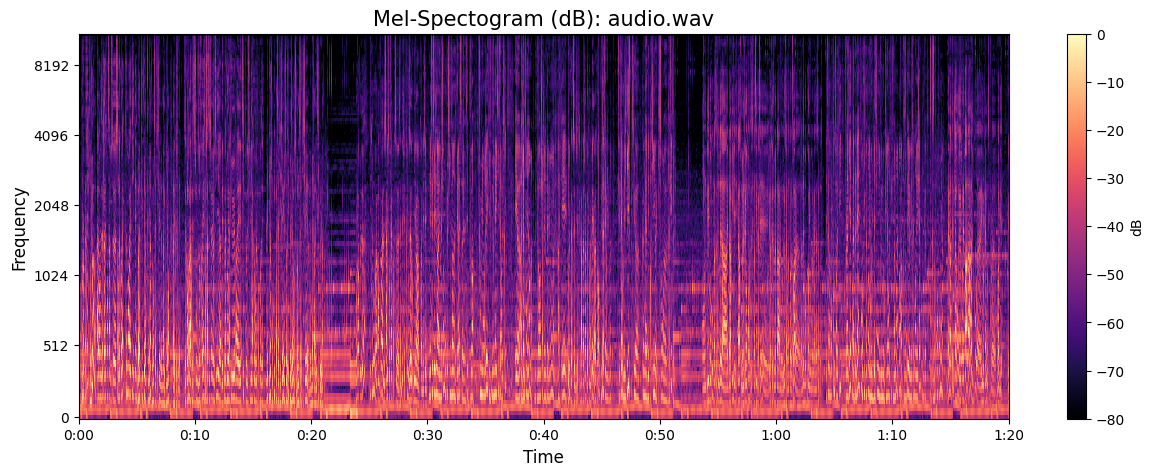

In [42]:
display_mel_spectogram(audiofile, n_fft=1024, hop_length=512)

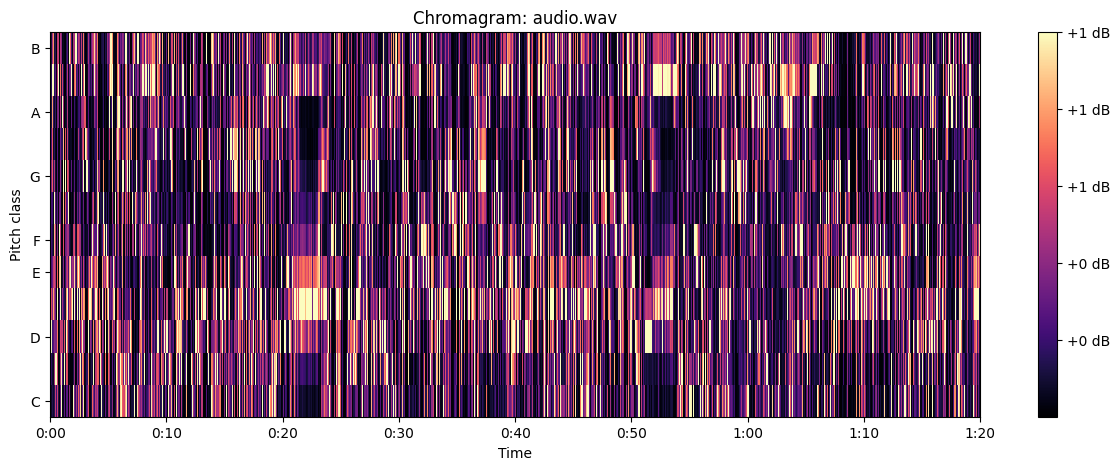

In [43]:
display_chromagram(audiofile)

In [38]:
transcript, confidence, words = azure_tts(audiofile, language)

CLOSING on SpeechRecognitionCanceledEventArgs(session_id=f9e0198cb84d4a3aa3842dd7a7e73e02, result=SpeechRecognitionResult(result_id=043264c896004f7d8d48a0a4b5991487, text="", reason=ResultReason.Canceled))
["Bonjour Patrick, Bonjour, alors vous êtes le responsable de ce centre de collecte, comment va l'activité bonne activité\xa0? Va très bien, vraiment satisfait de voir les clients avec le sourire. Vous êtes contents de la prestation que vous offrez\xa0? Ils sont satisfaits aussi des plages d'ouverture et des types de filières que vous leur proposez. Les clients sont hyper satisfaits. Je sais aussi que mes agences sont vraiment satisfaits de venir travailler si tous les matins.", "Bonjour à tous les 2 dites nous en quoi le service offert par ce cette déchetterie vous aide au quotidien dans votre métier\xa0? On est spécialisé dans la rénovation donc ce qui nous intéresse c'est de pouvoir tout mélanger et puis venir ici faire le tri et un gain de temps énorme de pouvoir recharger nos ca

### Transcript

In [44]:
print(transcript)

["Bonjour Patrick, Bonjour, alors vous êtes le responsable de ce centre de collecte, comment va l'activité bonne activité\xa0? Va très bien, vraiment satisfait de voir les clients avec le sourire. Vous êtes contents de la prestation que vous offrez\xa0? Ils sont satisfaits aussi des plages d'ouverture et des types de filières que vous leur proposez. Les clients sont hyper satisfaits. Je sais aussi que mes agences sont vraiment satisfaits de venir travailler si tous les matins.", "Bonjour à tous les 2 dites nous en quoi le service offert par ce cette déchetterie vous aide au quotidien dans votre métier\xa0? On est spécialisé dans la rénovation donc ce qui nous intéresse c'est de pouvoir tout mélanger et puis venir ici faire le tri et un gain de temps énorme de pouvoir recharger nos camions. Racheter. Et oui, parce que cette déchetterie est partagée entre point P et la plateforme. Tout à fait. Oui voilà, c'est très compétitif puisque comme il y a des parties qui sont gratuites.", "On uti

### Words

In [46]:
words

[{'Word': 'bonjour',
  'Offset': 1900000,
  'Duration': 3900000,
  'Confidence': 0.88210416},
 {'Word': 'patrick',
  'Offset': 5900000,
  'Duration': 4500000,
  'Confidence': 0.9012197},
 {'Word': 'bonjour',
  'Offset': 10500000,
  'Duration': 5700000,
  'Confidence': 0.91299427},
 {'Word': 'alors',
  'Offset': 16300000,
  'Duration': 3000000,
  'Confidence': 0.8742893},
 {'Word': 'vous',
  'Offset': 19400000,
  'Duration': 1100000,
  'Confidence': 0.84196615},
 {'Word': 'êtes',
  'Offset': 20600000,
  'Duration': 1800000,
  'Confidence': 0.86245143},
 {'Word': 'le',
  'Offset': 22500000,
  'Duration': 700000,
  'Confidence': 0.83045566},
 {'Word': 'responsable',
  'Offset': 23300000,
  'Duration': 4900000,
  'Confidence': 0.87519324},
 {'Word': 'de',
  'Offset': 28300000,
  'Duration': 700000,
  'Confidence': 0.90663046},
 {'Word': 'ce',
  'Offset': 29100000,
  'Duration': 3900000,
  'Confidence': 0.7844486},
 {'Word': 'centre',
  'Offset': 33100000,
  'Duration': 2500000,
  'Confiden

In [47]:
df = pd.DataFrame(words, columns=["Word", "Offset", "Duration", "Confidence"])
df["Offset_in_secs"] = df["Offset"] / 10000000
df["Duration_in_secs"] = df["Duration"] / 10000000
df

,Word,Offset,Duration,Confidence,Offset_in_secs,Duration_in_secs
0,bonjour,1900000,3900000,0.882104,0.19,0.39
1,patrick,5900000,4500000,0.901220,0.59,0.45
2,bonjour,10500000,5700000,0.912994,1.05,0.57
3,alors,16300000,3000000,0.874289,1.63,0.30
4,vous,19400000,1100000,0.841966,1.94,0.11
...,...,...,...,...,...,...
263,prennent,780200000,2000000,0.783069,78.02,0.20
264,aussi,782300000,2300000,0.833011,78.23,0.23
265,pour,784700000,5100000,0.951442,78.47,0.51
266,pouvoir,790200000,2800000,0.820497,79.02,0.28


## 4. Text search and extraction of the audio part

In [48]:
def text_search(text):
    """
    search a text
    """
    df_res = df[df["Word"] == text]
    offset_secs = df_res["Offset_in_secs"].values[0]
    duration_secs = df_res["Duration_in_secs"].values[0]

    return df_res, offset_secs, duration_secs

### 4.1Test 1

In [50]:
text_to_search = "prestation"

In [51]:
df_res, offset_secs, duration_secs = text_search(text_to_search)
df_res

,Word,Offset,Duration,Confidence,Offset_in_secs,Duration_in_secs
35,prestation,97700000,4000000,0.863117,9.77,0.4


In [52]:
offset_secs, duration_secs

(9.77, 0.4)

In [54]:
audio = AudioSegment.from_wav(audiofile)

lag = 500
start_time = offset_secs * 1000 - lag
duration_time = duration_secs * 1000
end_time = start_time + duration_time + lag * 2

extracted_audio = audio[start_time:end_time]
outputfile = text_to_search + '.wav'
extracted_audio.export(outputfile, format="wav")

<_io.BufferedRandom name='prestation.wav'>

In [55]:
Audio(outputfile, autoplay=False)

### 4.2 Test 2

In [56]:
text_to_search = "planète"

df_res, offset_secs, duration_secs = text_search("planète")
df_res

,Word,Offset,Duration,Confidence,Offset_in_secs,Duration_in_secs
219,planète,668500000,5300000,0.911087,66.85,0.53


In [57]:
audio = AudioSegment.from_wav(audiofile)

lag = 500
start_time = offset_secs * 1000 - lag
duration_time = duration_secs * 1000
end_time = start_time + duration_time + lag * 2

extracted_audio = audio[start_time:end_time]
outputfile = text_to_search + '.wav'
extracted_audio.export(outputfile, format="wav")

<_io.BufferedRandom name='planète.wav'>

In [58]:
Audio(outputfile, autoplay=False)

### 4.3 Test 3

In [59]:
text_to_search = "plateforme"

df_res, offset_secs, duration_secs = text_search(text_to_search)
df_res

,Word,Offset,Duration,Confidence,Offset_in_secs,Duration_in_secs
146,plateforme,445000000,4700000,0.766175,44.5,0.47


In [60]:
audio = AudioSegment.from_wav(audiofile)

lag = 500
start_time = offset_secs * 1000 - lag
duration_time = duration_secs * 1000
end_time = start_time + duration_time + lag * 2

extracted_audio = audio[start_time:end_time]
outputfile = text_to_search + '.wav'
extracted_audio.export(outputfile, format="wav")

<_io.BufferedRandom name='plateforme.wav'>

In [61]:
Audio(outputfile, autoplay=False)

## Test 4

In [64]:
text_to_search = "déchets"

df_res, offset_secs, duration_secs = text_search(text_to_search)
df_res

,Word,Offset,Duration,Confidence,Offset_in_secs,Duration_in_secs
242,déchets,722200000,4400000,0.920509,72.22,0.44


In [65]:
audio = AudioSegment.from_wav(audiofile)

lag = 500
start_time = offset_secs * 1000 - lag
duration_time = duration_secs * 1000
end_time = start_time + duration_time + lag * 2

extracted_audio = audio[start_time:end_time]
outputfile = text_to_search + '.wav'
extracted_audio.export(outputfile, format="wav")

<_io.BufferedRandom name='déchets.wav'>

In [66]:
Audio(outputfile, autoplay=False)